In [1]:
import random
# from cellular_automaton import *
import itertools
import numpy as np
from scipy import ndimage
import os
import scipy
from copy import copy
from copy import deepcopy
from skimage.measure import block_reduce
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import imageio
# import ndimage.
%matplotlib inline

In [2]:
from utils_cellular_automata import *
from scipy.stats import bernoulli
from scipy import stats
from scipy import signal 

path_img_dest = 'gifs/gifs_numpy/'

In [3]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import Tensor
import torch
import torch.nn.functional as F

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
def survive_and_birth_individual_list_3D_mask(neighbors, means, mask, values, survives, births, cells_active):
    neighbors = np.asarray(neighbors)
    means = np.asarray(means)
    values = np.asarray(values)
    survives = np.asarray(survives)
    births = np.asarray(births)
    LIMIT_UP = 0.75
    LIMIT_DOWN = 0.15
    
    
    z,y,x = np.where(mask==1)
    
    grid_new = copy(values)
    for i in range(1,np.shape(neighbors)[0]-1):
        if i in z:
            for j in range(1,np.shape(neighbors)[1]-1):
                if j in y:
                    for k in range(1,np.shape(neighbors)[2]-1):
                        if k in x:

                            # SURVIVE
                            if LIMIT_DOWN < grid_new[i,j,k] < LIMIT_UP and cells_active[i,j,k] > 0: 
                                np.random.rand()
                                grid_new[i,j,k] = np.squeeze([np.mean((means[i,j,k], values[i,j,k]+.05)) if neighbors[i,j,k] in survives else values[i,j,k]-.1])
                                #grid_new[i,j,k] = np.squeeze([values[i,j,k]+.1 if neighbors[i,j,k] in survives[i,j,k] else values[i,j,k]-.1])
                            # BIRTH
                            elif grid_new[i,j,k] < LIMIT_DOWN and cells_active[i,j,k] > 0:
                                rand_close_to_alive = 0.35
                                last_cell_state = grid_new[i,j,k]
                                if neighbors[i,j,k] in births:
                                    grid_new[i,j,k] = np.mean((rand_close_to_alive, means[i,j,k], last_cell_state))
                            # LIMIT
                            elif grid_new[i,j,k] > LIMIT_UP:
                                rand_close_to_alive = np.mean((values[i,j,k]-.5, means[i,j,k]))
                                grid_new[i,j,k] = rand_close_to_alive
                            else: pass
    
    return grid_new

In [4]:
path_data = '/data/OMM/Datasets/LIDC_other_formats/LUNA_inpainted_cubes_for_GAN_v2/'
files = os.listdir(f'{path_data}original/')
files = np.sort(files)
print(f'total files = {len(files)}')
block_name = files[116]

total files = 2292


In [5]:
last, orig, mask, mask_lungs = get_raw_nodule(path_data, files[0])
np.shape(last), np.shape(orig)

((64, 64, 64), (64, 64, 64))

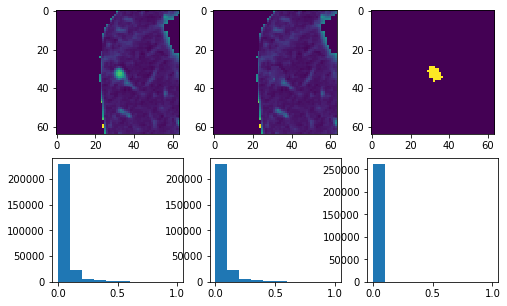

In [6]:
fig, ax = plt.subplots(2,3, figsize=(8,5))
ax[0,0].imshow(orig[32])
ax[0,1].imshow(last[32])
ax[0,2].imshow(mask[32])
ax[1,0].hist(orig.flatten());
ax[1,1].hist(last.flatten());
ax[1,2].hist(mask.flatten());

In [7]:
# Sort nodules by size (OLD VERSION)
# the output is an ordered list of lists [index, sum(mask)], order by the sum(mask)
ndl_idx_vols = []
for idx, i in tqdm(enumerate(files), total=len(files)):
    last, orig, mask, _ = get_raw_nodule(path_data, i)
    last, orig
    ndl_idx_vols.append([idx, np.sum(mask)])
ndl_idx_vols.sort(key= lambda x: x[1])

In [12]:
ndl_sorted = ndl_idx_vols
ndl_sorted[0], ndl_sorted[-1]

([2149, 8.0], [1381, 35016.0])

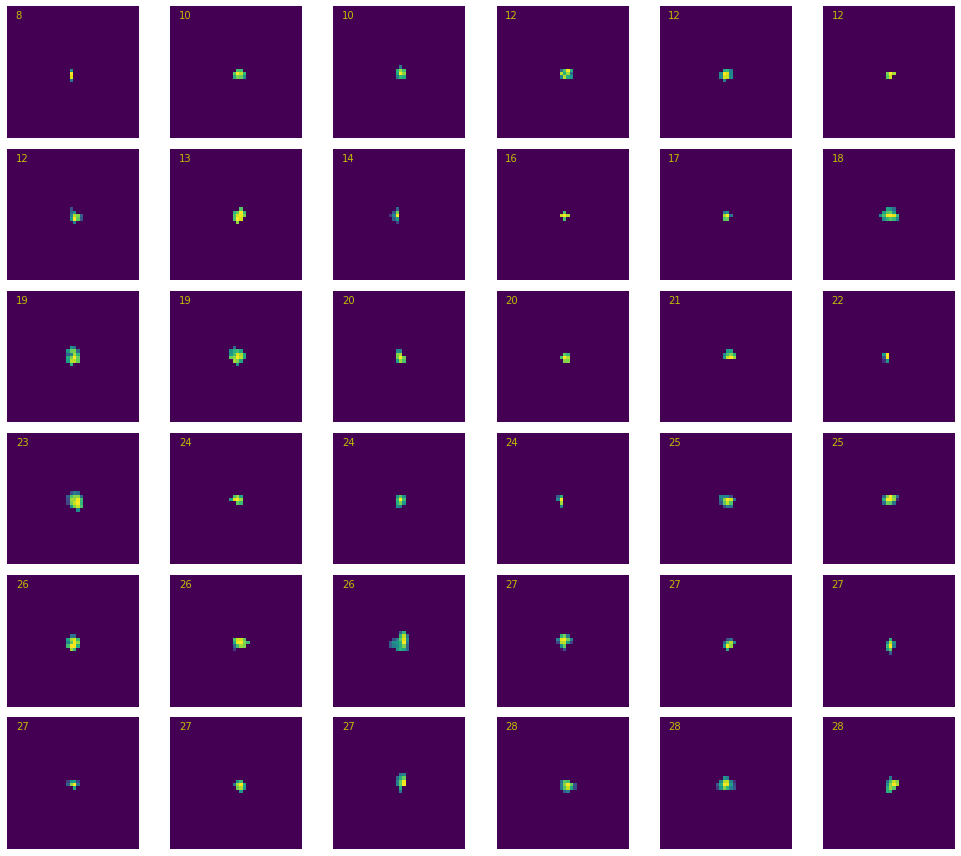

In [82]:
# Plot the nodules (center slice) using the median of the mask
zoom = 13
rows = 6
cols = 6
fig, ax = plt.subplots(rows,cols,figsize=(14, 12))
for idx, (i, pixels) in enumerate(ndl_sorted):
    if idx ==rows*cols:break
    ndl_to_read = files[i]
    last, orig, mask, _ = get_raw_nodule(path_data, ndl_to_read)
    # get only the nodules, set the rest to zero
    z,y,x = np.where(mask==0)
    ndl_only = copy(orig)
    ndl_only[z,y,x]=0
    # right centroid
    z,y,x = np.where(mask==1)
    zz = int(np.median(z))
    ax[idx//(rows), idx%cols].imshow(ndl_only[zz][zoom:-zoom,zoom:-zoom])
    ax[idx//(rows), idx%cols].text(2,3, int(pixels), color='y')
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()

In [13]:
nodules_sorted = []
files_sorted = []
zyx_min_max_len = []
for idx, i in tqdm(enumerate(ndl_sorted), total=len(ndl_sorted)):
    ndl_to_read = files[i[0]]
    last, orig, mask, _ = get_raw_nodule(path_data, ndl_to_read)
    # get only the nodules, set the rest to zero
    z,y,x = np.where(mask==0)
    ndl_only = copy(orig)
    ndl_only[z,y,x]=0
    # crop only the nodule
    z,y,x = np.where(mask==1)
    z_min = int(np.min(z)); z_max = int(np.max(z))
    y_min = int(np.min(y)); y_max = int(np.max(y))
    x_min = int(np.min(x)); x_max = int(np.max(x))
    ndl_only = ndl_only[z_min:z_max+1, y_min:y_max+1, x_min:x_max+1]
    # center the cropped nodule in a new zeros matrix
    z_len, y_len, x_len = np.shape(ndl_only)
    padz1, pady1, padx1 = int(32-(np.ceil(z_len/2))), int(32-(np.ceil(y_len/2))), int(32-(np.ceil(x_len/2)))
    padz2, pady2, padx2 = int(32-(np.floor(z_len/2))), int(32-(np.floor(y_len/2))), int(32-(np.floor(x_len/2)))
    ndl_only = np.pad(ndl_only,((padz1, padz2),(pady1, pady2),(padx1, padx2)),mode='constant', constant_values=0)
    nodules_sorted.append(ndl_only)
    files_sorted.append(ndl_to_read)
    zyx_min_max_len.append((z_min, y_min, x_min, z_max, y_max, x_max, z_len, y_len, x_len))

In [95]:
# np.savez_compressed('nodules_sorted2.npz', nodules_sorted)

In [96]:
# np.save('files_sorted.npy', files_sorted)
# np.save('zyx_min_max_len_sorted.npy', zyx_min_max_len)

In [14]:
len(nodules_sorted)

2292

In [15]:
a = np.load('/home/om18/Downloads/nodules_sorted2.npz')
a = a.f.arr_0
len(a)

2292

In [ ]:
for i in nodul

### previous version

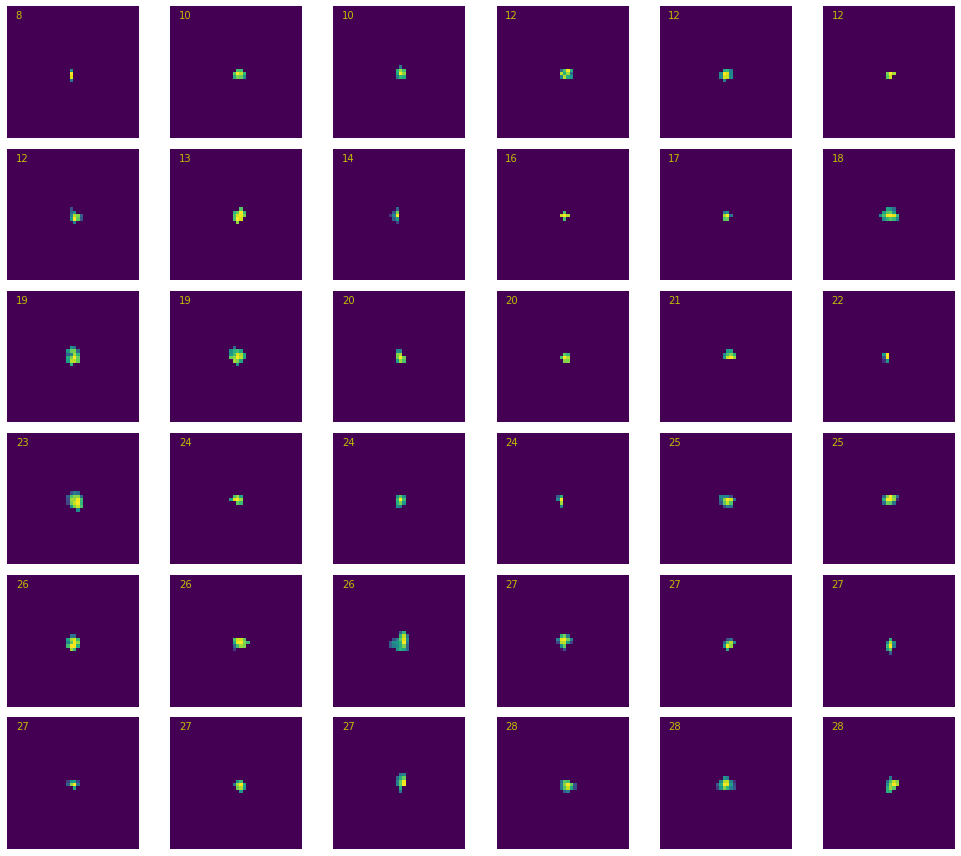

In [285]:
# Plot the nodules (center slice) using the median of the mask
zoom = 13
rows = 6
cols = 6
fig, ax = plt.subplots(rows,cols,figsize=(14, 12))
for idx, i in enumerate(ndl_sorted):
    if idx ==rows*cols:break
    ndl_to_read = files[i[0]]
    last, orig, mask, _ = get_raw_nodule(path_data, ndl_to_read)
    # get only the nodules, set the rest to zero
    z,y,x = np.where(mask==0)
    ndl_only = copy(orig)
    ndl_only[z,y,x]=0
    # right centroid
    z,y,x = np.where(mask==1)
    zz = int(np.median(z))
    ax[idx//(rows), idx%cols].imshow(ndl_only[zz][zoom:-zoom,zoom:-zoom])
    ax[idx//(rows), idx%cols].text(2,3, int(i[1]), color='y')
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()

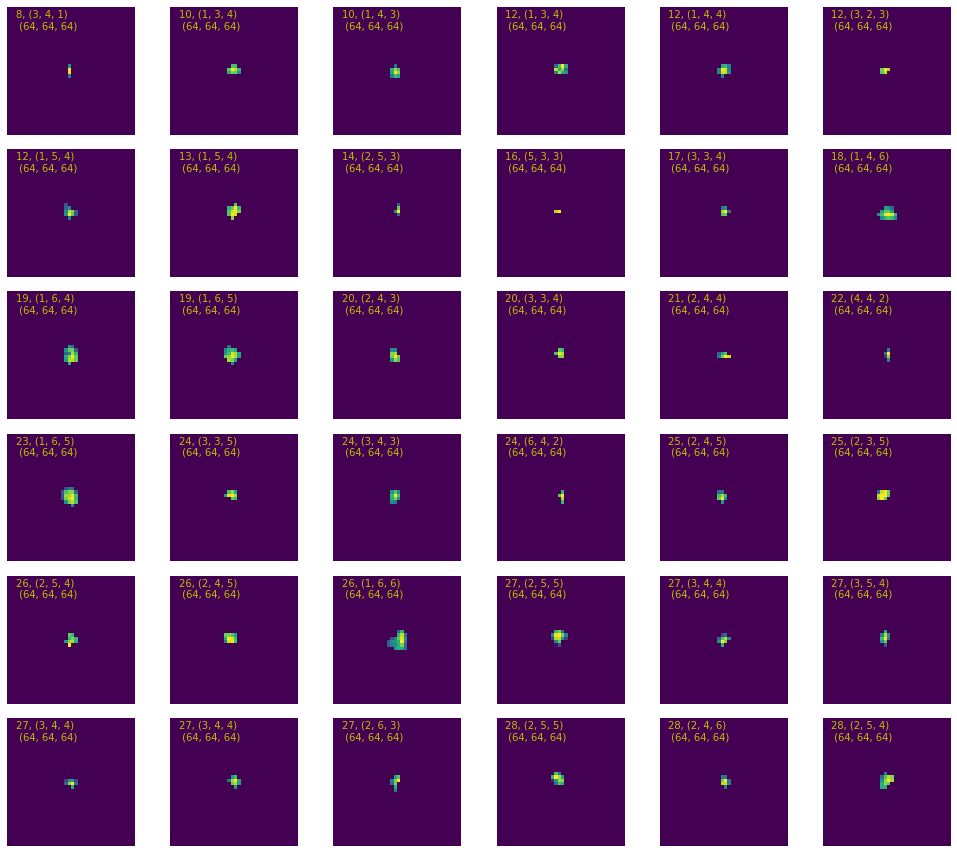

In [300]:
# crop only the nodule and and paste them into a 64x64x64 zeros matrix
zoom = 13
rows = 6
cols = 6
fig, ax = plt.subplots(rows,cols,figsize=(14, 12))
for idx, i in enumerate(ndl_sorted):
    if idx ==rows*cols:break
    ndl_to_read = files[i[0]]
    last, orig, mask, _ = get_raw_nodule(path_data, ndl_to_read)
    # get only the nodules, set the rest to zero
    z,y,x = np.where(mask==0)
    ndl_only = copy(orig)
    ndl_only[z,y,x]=0
    # crop only the nodule
    z,y,x = np.where(mask==1)
    z_min = int(np.min(z)); z_max = int(np.max(z))
    y_min = int(np.min(y)); y_max = int(np.max(y))
    x_min = int(np.min(x)); x_max = int(np.max(x))
    ndl_only = ndl_only[z_min:z_max+1, y_min:y_max+1, x_min:x_max+1]
    # center the cropped nodule in a new zeros matrix
    z_len, y_len, x_len = np.shape(ndl_only)
    padz1, pady1, padx1 = int(32-(np.ceil(z_len/2))), int(32-(np.ceil(y_len/2))), int(32-(np.ceil(x_len/2)))
    padz2, pady2, padx2 = int(32-(np.floor(z_len/2))), int(32-(np.floor(y_len/2))), int(32-(np.floor(x_len/2)))
    ndl_only = np.pad(ndl_only,((padz1, padz2),(pady1, pady2),(padx1, padx2)),mode='constant', constant_values=0)
        
    labeled, nr = ndimage.label(ndl_only)
    ax[idx//(rows), idx%cols].imshow(ndl_only[31][zoom:-zoom,zoom:-zoom])
    ax[idx//(rows), idx%cols].text(2,6, f'{int(i[1])}, {z_len, y_len, x_len}\n {np.shape(ndl_only)}', color='y')
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()

In [302]:
nodules_sorted = []
for idx, i in tqdm(enumerate(ndl_sorted), total=len(ndl_sorted)):
    ndl_to_read = files[i[0]]
    last, orig, mask, _ = get_raw_nodule(path_data, ndl_to_read)
    # get only the nodules, set the rest to zero
    z,y,x = np.where(mask==0)
    ndl_only = copy(orig)
    ndl_only[z,y,x]=0
    # crop only the nodule
    z,y,x = np.where(mask==1)
    z_min = int(np.min(z)); z_max = int(np.max(z))
    y_min = int(np.min(y)); y_max = int(np.max(y))
    x_min = int(np.min(x)); x_max = int(np.max(x))
    ndl_only = ndl_only[z_min:z_max+1, y_min:y_max+1, x_min:x_max+1]
    # center the cropped nodule in a new zeros matrix
    z_len, y_len, x_len = np.shape(ndl_only)
    padz1, pady1, padx1 = int(32-(np.ceil(z_len/2))), int(32-(np.ceil(y_len/2))), int(32-(np.ceil(x_len/2)))
    padz2, pady2, padx2 = int(32-(np.floor(z_len/2))), int(32-(np.floor(y_len/2))), int(32-(np.floor(x_len/2)))
    ndl_only = np.pad(ndl_only,((padz1, padz2),(pady1, pady2),(padx1, padx2)),mode='constant', constant_values=0)
    nodules_sorted.append(ndl_only)

In [323]:
np.savez_compressed('nodules_sorted.npz', nodules_sorted)

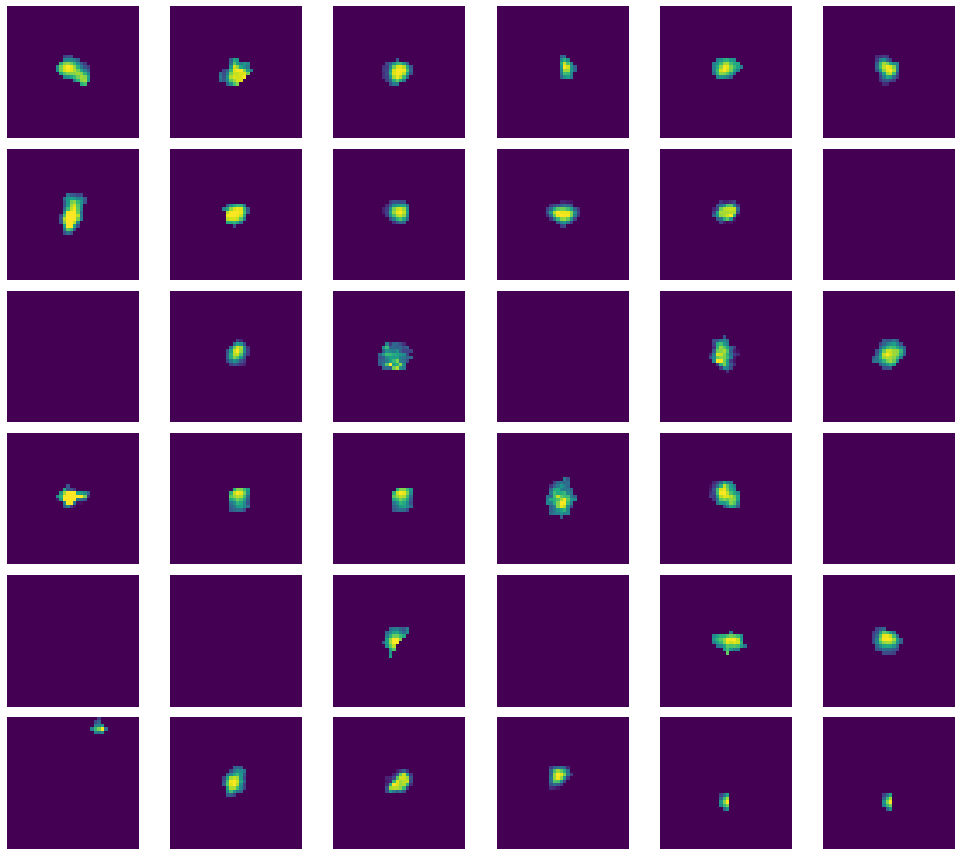

In [313]:
# plot sorted and centered nodules
zoom = 13
rows = 6
cols = 6
offset = 1200
fig, ax = plt.subplots(rows,cols,figsize=(14, 12))
for idx in range(36):
    ax[idx//(rows), idx%cols].imshow(nodules_sorted[idx+offset][31][zoom:-zoom,zoom:-zoom])
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()

In [318]:
nodules_smaller = [i[16:-16, 16:-16, 16:-16] for idx, i in enumerate(nodules_sorted) if idx<100]
np.shape(nodules_smaller)

(100, 32, 32, 32)

In [317]:
survive_single = [np.random.randint(0,27) for i in range(15)]
survive_single = np.sort(survive_single)
birth_single = [np.random.randint(2,12) for i in range(5)]
birth_single = np.sort(birth_single)



array([ 0,  1,  2,  3,  4,  5,  5,  6,  7, 10, 11, 12, 15, 19, 25])

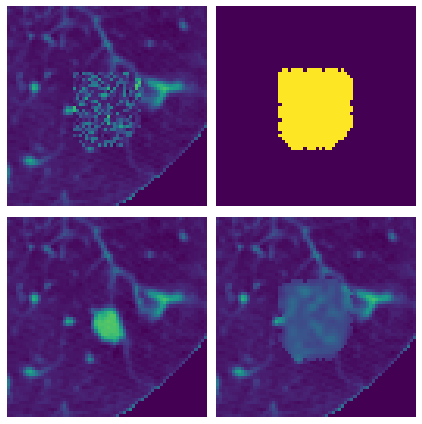

In [9]:
survive_single = list(range(27))
_ = [survive_single.remove(i) for i in [4,6,8,10]]
survive_single = [np.random.randint(0,27) for i in range(15)]
birth_single = [np.random.randint(2,12) for i in range(5)]
birth_single = np.sort(birth_single)
survive_single = np.sort(survive_single)
iter_total = 20


path_gifs1 = 'gifs/images_before_gifs/'
path_gifs2 = 'gifs/images_before_gifs2/'
path_gifs3 = 'gifs/images_before_gifs3/'
path_gifs4 = 'gifs/images_before_gifs4/'
grid_patches = []
cells_actives = []
grid_filtereds = []
diffs = []

last, orig, mask, mask_lungs = get_raw_nodule(path_data, block_name)
grid_patch, cells_active = add_seed_3D(last)
mask = ndimage.binary_dilation(mask, iterations=2)

for i in tqdm(range(iter_total)):
    grid_patches.append(grid_patch)
    cells_actives.append(cells_active)
    
    grid_prev = copy(grid_patch)
#     cells_active = ndimage.binary_dilation(cells_active, iterations=2)
    grid_neigh, grid_means = count_neighbors_and_get_means_3D_mask(grid_patch, mask, threshold=.2)
    grid_patch = survive_and_birth_individual_list_3D_mask(grid_neigh, grid_means, mask, grid_patch, survive_single, 
                                                         birth_single, cells_active)
    grid_filtered = filter_nodule_generated3_3D(grid_patch, cells_active)
    cells_active, grid_change_dilated = update_grid_cells_active(cells_active, grid_prev, grid_patch)
    
    grid_filtereds.append(grid_filtered)
    plot_for_gif_classes(grid_filtered[31], iter_total, i, (0,1))
    plot_for_gif_classes(cells_active[31], iter_total, i, (0,1), fold=path_gifs2)
    plot_for_gif_classes(grid_patch[31], iter_total, i, (0,1), fold=path_gifs3)
    
    diffs.append(np.sum(np.abs(orig - grid_filtereds)))
    
    # dilate to prevent having a fixed suare-like limit
    # mask = ndimage.binary_dilation(mask)
    
text_survive, text_birth = format_survive_and_birth_texts(survive_single, birth_single)
rule_name = f'v1x_{text_survive}_{text_birth}'
images = make_gif(path_gifs1)
imageio.mimsave(f'{path_img_dest}{rule_name}.gif', images)
images_cells_active = make_gif(path_gifs2)
imageio.mimsave(f'{path_img_dest}{rule_name}_active.gif', images_cells_active)
images_patch = make_gif(path_gifs3)
imageio.mimsave(f'{path_img_dest}{rule_name}_raw.gif', images_patch)
plot_22(grid_patch, cells_active, orig, grid_filtered, 31, 6)

In [13]:
last, orig, mask, mask_lungs = get_raw_nodule(path_data, block_name)
print(np.shape(last), np.shape(orig), np.shape(mask), np.shape(mask_lungs))

(64, 64, 64) (64, 64, 64) (64, 64, 64) (64, 64, 64)


In [62]:
class Dataset3D(Dataset):
    def __init__(self, path_data, files, transform = False):
        self.path_last = f'{path_data}inpainted inserted/'
        self.path_orig = f'{path_data}original/'
        self.path_mask_lungs = f'{path_data}mask lungs/'
        self.path_mask = f'{path_data}mask/'
        self.path_data = path_data
        self.files = files
        self.transform = transform
        
    def __len__(self):
        return len(self.files)
    
    def rotate_axis(self, img_, axes):
        """Rotate around the three axes maximum three times per axis"""
        img_ = copy.copy(img_)
        num_rot = 1#np.random.randint(1,4)
        img_ = np.rot90(img_, num_rot, axes)
        return img_

    def __getitem__(self, idx):
        last = np.fromfile(f'{self.path_last}{self.files[idx]}',dtype='int16').astype('float32').reshape((64,64,64))
        orig = np.fromfile(f'{self.path_orig}{self.files[idx]}',dtype='int16').astype('float32').reshape((64,64,64))
        mask = np.fromfile(f'{self.path_mask}{self.files[idx]}',dtype='int16').astype('float32').reshape((64,64,64))
        img = last
        
        if self.transform:
            if np.random.rand() > 0.5:
                img = self.rotate_axis(img, (0,1))
            if np.random.rand() > 0.5:
                img = self.rotate_axis(img, (0,2))
            if np.random.rand() > 0.5:
                img = self.rotate_axis(img, (1,2))
                            
        img = np.expand_dims(img,0)
        img = Tensor(img.copy())
        return img

In [63]:
dataset_train = Dataset3D(path_data, files)

In [64]:
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=False)

In [65]:
dataloader_iter = iter(dataloader_train)
iimage = next(dataloader_iter)
print(np.shape(iimage))

torch.Size([16, 1, 64, 64, 64])


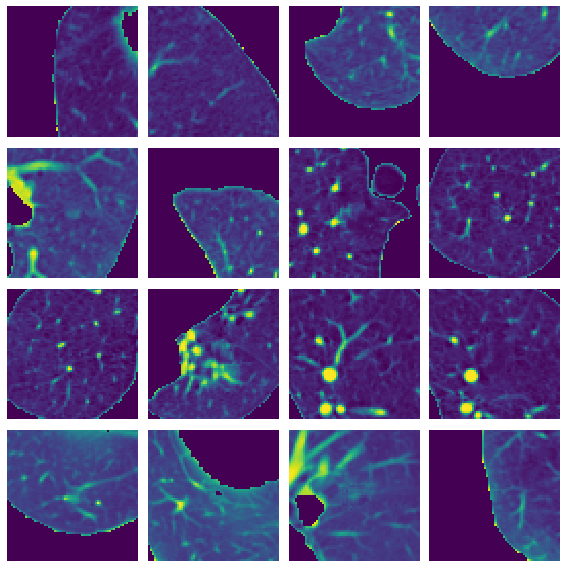

In [66]:
fig, ax = plt.subplots(4,4, figsize=(8,8))
for idx, i in enumerate(iimage):
    ax[idx//4, idx%4].imshow(i[0][31])
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()

In [109]:
class Actor(nn.Module):
    '''WARNING: the adaptiveMaxPool was added but its performance was not evaluated'''
    def __init__(self, action_dim, max_action):
        super(Actor, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3)
        self.bn1 = nn.BatchNorm3d(16)
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=action_dim, kernel_size=3)
        self.bn2 = nn.BatchNorm3d(action_dim)
        self.adaptiveMaxPool = nn.AdaptiveMaxPool3d(1)
        self.max_action = max_action

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.max_action * torch.tanh(self.adaptiveMaxPool(x))
        x = torch.squeeze(x)
        print(x.shape)
        return x

In [110]:
max_action = Tensor(1)
model = Actor(27, max_action)

In [319]:
epochs=1
for epoch in tqdm(range(epochs), total = len(range(epochs)), desc=f'training fold'):
    model.train()
    for idx, (x_train) in enumerate(dataloader_train):
        model(x_train)

torch.Size([16, 27])


KeyboardInterrupt: 